In [2]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

In [73]:
def concat_ones(data):
    
    size = len(data)
    new_data = np.concatenate((data, np.ones((size, 1))), axis=1)
    
    return new_data

def projection_mse(actual, projected):    
    return np.mean((projected - actual)**2)

def prepare_data():
    
    left_uv = concat_ones(np.load("left_uv.npy"))
    right_uv = concat_ones(np.load("right_uv.npy"))
    img_left = plt.imread("Left.jpg")
    img_right = plt.imread("Right.jpg")

    return left_uv, right_uv, img_left, img_right

def homography(u2Trans, v2Trans, uBase, vBase):
    
    size = len(u2Trans)
    u2Trans, v2Trans = u2Trans.reshape((-1,1)), v2Trans.reshape((-1,1))
    
    trans_uv = np.concatenate((u2Trans, v2Trans, np.ones((size, 1))), axis=1)
    
    A = []

    for i, ele in enumerate(trans_uv):
        
        u = uBase[i]
        v = vBase[i]

        eq1 = np.concatenate(([0,0,0], -ele, ele * v))
        eq2 = np.concatenate(( -ele, [0,0,0], ele * u))

        A.append(eq1)
        A.append(eq2)


    A = np.array(A)

    _, _, V = np.linalg.svd(A)
    
    # Reshape last column of V to get homography matrix 
    H = V.T[:,-1].reshape((3,3))  # Use the transpose of V since np.linalg.svd returns transpose of results
    
    # Divide matrix H with the last diagonal element
    H = H / H[2,2]    
    
    return H 

def projected_coordinates(left_uv, H):

    projections = H @ left_uv[:,:,None]
    projections = projections.reshape((left_uv.shape))
    projections /= projections[:,-1].reshape((-1,1))
    
    return projections

left_uv, right_uv, img_left, img_right = prepare_data()
H = homography(left_uv[:,0], left_uv[:,1], right_uv[:,0], right_uv[:,1])
projections = projected_coordinates(left_uv, H)
im_warped = cv2.warpPerspective(img_left, H, img_left.shape[:2])

In [86]:
u2Trans, v2Trans, uBase, vBase = left_uv[:,[0]], left_uv[:,[1]], right_uv[:,[0]], right_uv[:,[1]]

H = homography(u2Trans, v2Trans, uBase, vBase)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 0 dimension(s)

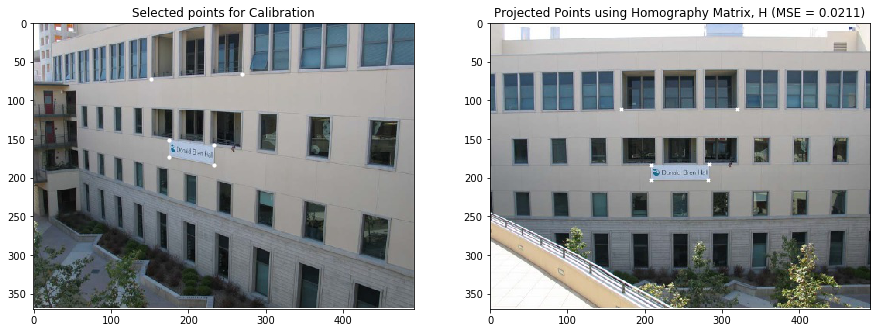

In [38]:
# Show images
fig, ax = plt.subplots(1, 2, figsize=(15,10))

# Show selected points on input images
ax[0].imshow(img_left)
ax[0].scatter(left_uv[:,0], left_uv[:,1], s=10, c='w')
ax[0].set_title("Selected points for Calibration")

ax[1].imshow(img_right)
ax[1].scatter(projections[:,0], projections[:,1], s=10, c='w', marker='x')
ax[1].set_title("Projected Points using Homography Matrix, H (MSE = %.4f)"%(projection_mse(right_uv, projections)))

plt.show()

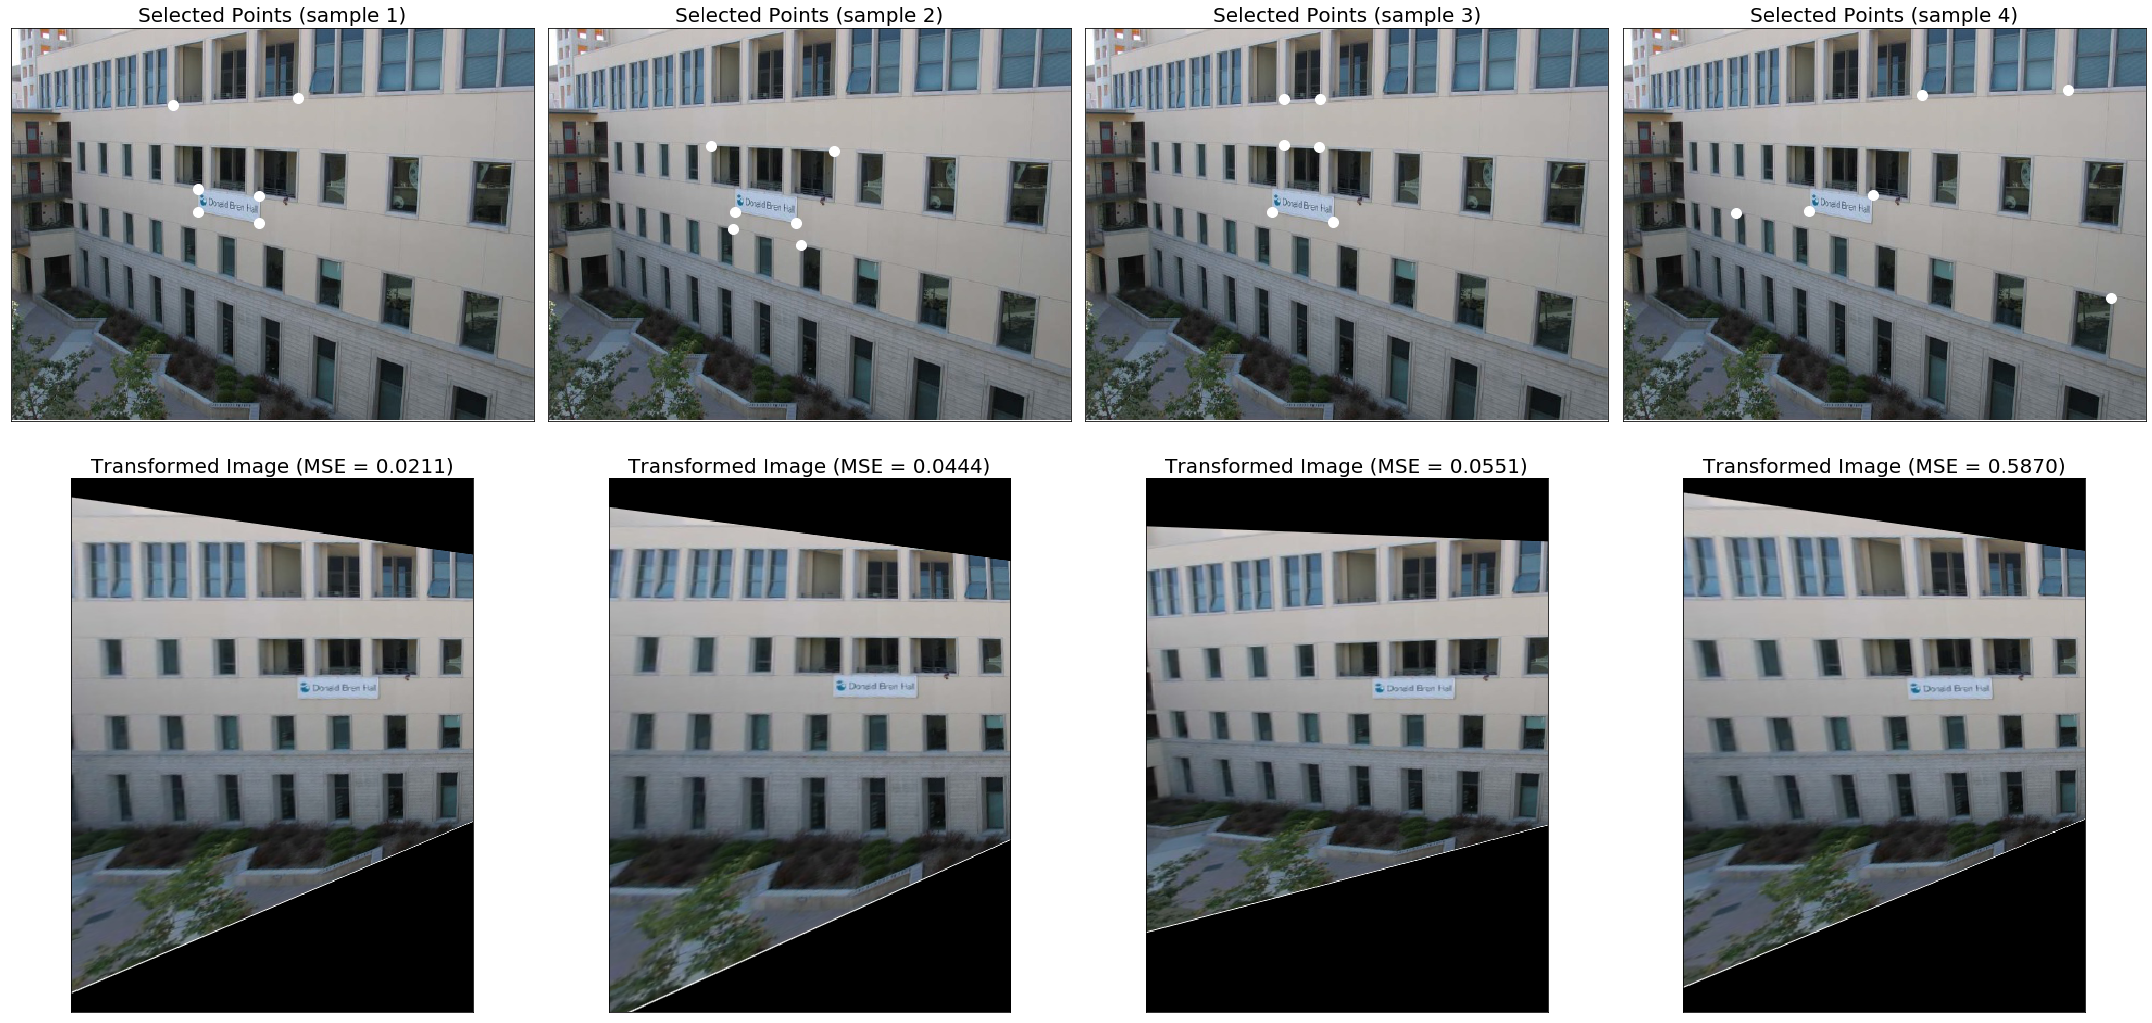

In [72]:
x = []

fig, ax = plt.subplots(2, 4, figsize=(30,15))
for i, j in enumerate(["", "_3","_4","_2",]):
# for i in [""]:
    
    left_uv = concat_ones(np.load("left_uv{}.npy".format(j)))
    right_uv = concat_ones(np.load("right_uv{}.npy".format(j)))
    img_left = plt.imread("Left.jpg")
    img_right = plt.imread("Right.jpg")
    H = homography(left_uv[:,0], left_uv[:,1], right_uv[:,0], right_uv[:,1])
    projections = projected_coordinates(left_uv, H)
    im_warped = cv2.warpPerspective(img_left, H, img_left.shape[:2])
    
    x.append(projection_mse(right_uv, projections))
    
    # Show images


    # Show selected points on input images
    ax[0, i].imshow(img_left)
    ax[0, i].scatter(left_uv[:,0], left_uv[:,1], s=100, c='w')
    ax[0, i].set_title("Selected Points (sample {})".format(i+1), fontsize=20)
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])

    ax[1, i].imshow(im_warped)
    ax[1, i].set_title("Transformed Image (MSE = %.4f)"%(projection_mse(right_uv, projections)), fontsize=20)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

#     ax[0, i].imshow(img_right)
#     ax[0, i].scatter(right_uv[:,0], right_uv[:,1], s=10, c='w', marker='x')
#     ax[0, i].set_title("Target Image", fontsize=20)
#     ax[0, i].set_xticks([])
#     ax[0, i].set_yticks([])

plt.tight_layout()
plt.show()